In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels

In [2]:
# Load the cleaned data from the CSV file and print its shape
cleaned_data = pd.read_csv('../data/cleaned-data.csv')
print(f"Shape of the cleaned data: {cleaned_data.shape}")

Shape of the cleaned data: (41176, 34)


##### Data Splitting

In [3]:
# Split the data into features (X) and target (y)
X = cleaned_data.drop(columns=['y'])  
y = cleaned_data['y']  

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Neural Network

##### Step 1: Apply Correlation Matrix and Remove Correlated Features

In [12]:
# Calculate correlation matrix
corr_matrix = X_train.corr()

# Set a threshold for correlation (e.g., 0.8)
threshold = 0.8
correlated_features = set()

# Loop through the matrix to find correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop the correlated features
X_train = X_train.drop(columns=correlated_features)
X_test = X_test.drop(columns=correlated_features)

print(X_train.head())

            age  housing  loan  contact  duration  campaign  pdays  previous  \
27498  1.629107        1     0        0 -0.838079 -0.204990    1.0 -0.349551   
20984  0.381573        0     0        0 -0.437003 -0.565963    1.0 -0.349551   
34370 -0.865962        0     0        0  0.743087 -0.565963    1.0 -0.349551   
17255  1.245251        0     0        0 -0.517990 -0.204990    1.0 -0.349551   
15326 -0.865962        1     0        0 -0.668393 -0.204990    1.0 -0.349551   

       emp.var.rate  cons.price.idx  ...  marital_married  marital_single  \
27498          -0.1       -0.649100  ...             True           False   
20984           1.4       -0.227562  ...             True           False   
34370          -1.8       -1.179479  ...            False            True   
17255           1.4        0.591329  ...             True           False   
15326           1.4        0.591329  ...            False            True   

       poutcome_nonexistent  poutcome_success  education

##### Step 2: Apply SMOTE (Synthetic Minority Over-sampling Technique)

In [13]:
# Apply SMOTE on the training data
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Handle data imbalance using Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42, kind="borderline-1")
X_train_smote, y_train_smote = borderline_smote.fit_resample(X_train, y_train)

print(f"Training set after SMOTE: {Counter(y_train_smote)}")

Training set after SMOTE: Counter({0: 25576, 1: 25576})


##### Step 3: Define and Compile Neural Network Model

c:\Users\Thinkpad\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.8059 - loss: 0.5445 - val_accuracy: 0.8491 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 2/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8791 - loss: 0.3677 - val_accuracy: 0.8591 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 3/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8868 - loss: 0.3265 - val_accuracy: 0.8587 - val_loss: 0.3243 - learning_rate: 0.0010
Epoch 4/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8910 - loss: 0.3050 - val_accuracy: 0.8487 - val_loss: 0.3390 - learning_rate: 0.0010
Epoch 5/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8964 - loss: 0.2928 - val_accuracy: 0.8421 - val_loss: 0.3609 - learning_rate: 0.0010
Epoch 6/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8961 - loss: 0.2919 - val_accuracy: 0.8628 - val_loss: 0.3193 - learning_rate: 0.0010
Epoch 7/20
1599/1599 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.

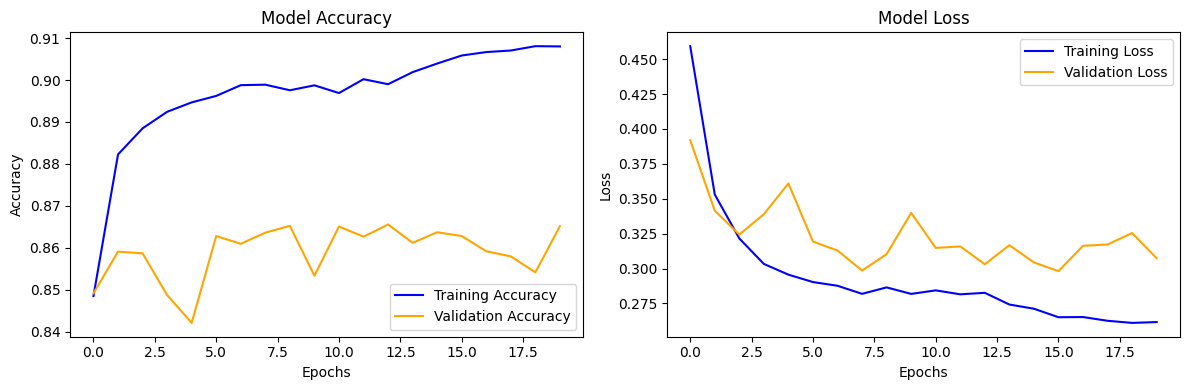

In [44]:
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


# Use a reduced learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model with adjusted learning rate
optimizer = Adam(learning_rate=0.001)  # Starting learning rate

# Define the Neural Network
nn_model = Sequential([
    Dense(32, activation='relu', kernel_regularizer=l2(0.001), input_dim=X_train_smote.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_smote, y_train_smote, validation_data=(X_test, y_test),
                        epochs=20, batch_size=32, verbose=1,callbacks=[reduce_lr])



# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

##### Step 4: Evaluate Model and Print Results

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8419 - loss: 0.3487
Test Loss: 0.33846113085746765
Test Accuracy: 0.848227322101593
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7265
           1       0.43      0.88      0.58       971

    accuracy                           0.85      8236
   macro avg       0.71      0.86      0.74      8236
weighted avg       0.92      0.85      0.87      8236

Confusion Matrix:
[[6128 1137]
 [ 113  858]]


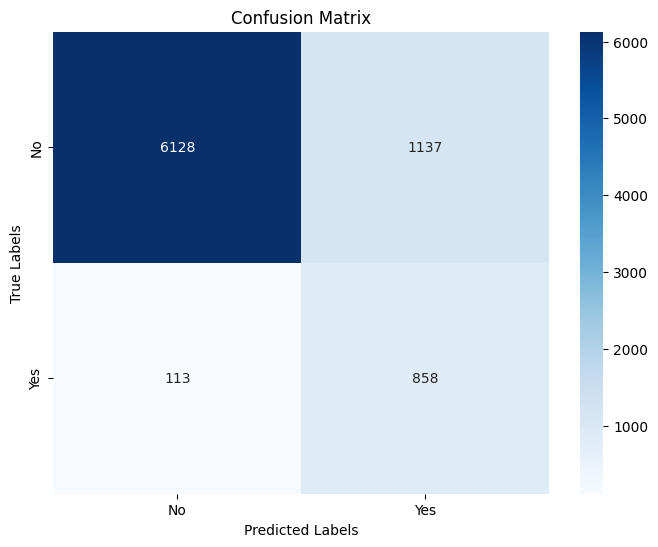

In [53]:
# Predict on the test set
y_pred = nn_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot 
class_names = ['No', 'Yes']  
plot_confusion_matrix(cm, class_names)

### Random Forest

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     10961
           1       0.52      0.76      0.61      1392

    accuracy                           0.89     12353
   macro avg       0.74      0.83      0.78     12353
weighted avg       0.92      0.89      0.90     12353


Confusion Matrix (Adjusted Threshold):
[[9972  989]
 [ 338 1054]]


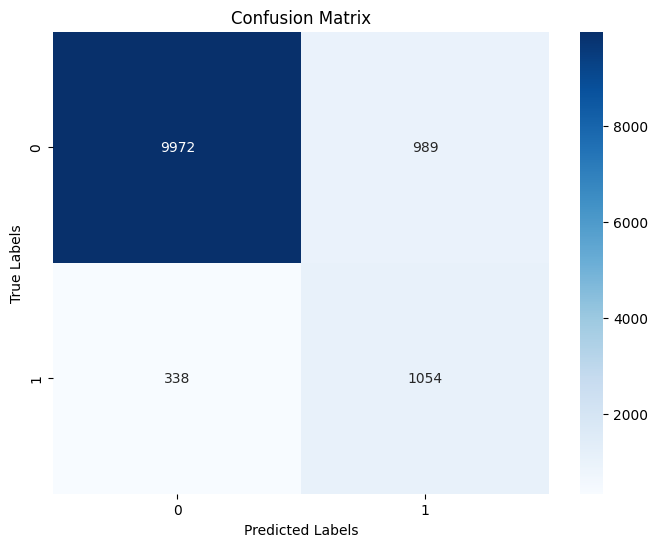


AUC-ROC Score: 0.94


In [19]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handle data imbalance using Borderline-SMOTE
borderline_smote = BorderlineSMOTE(random_state=42, kind="borderline-1")
X_train_smote, y_train_smote = borderline_smote.fit_resample(X_train, y_train)

# Initialize the Random Forest Classifier with manual class weights
class_weights = {0: 1, 1: 5}  # Adjust weights as needed
rf = RandomForestClassifier(
    random_state=42,
    class_weight=class_weights
)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for AUC-ROC
    cv=3,
    n_jobs=-1
)

# Fit GridSearchCV to the SMOTE-resampled data
grid_search.fit(X_train_smote, y_train_smote)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Train the best Random Forest model
best_rf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Adjust classification threshold
threshold = 0.4  # Adjust as needed based on results
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted))

cm = confusion_matrix(y_test, y_pred_adjusted)
print("\nConfusion Matrix (Adjusted Threshold):")
print(cm)

# Plot Confusion Matrix
plot_confusion_matrix(cm, unique_labels(y_test))

# AUC-ROC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC-ROC Score: {auc:.2f}")

##### Comaparison plots


##### ROC Curve for both models
- This will compare the classification performance in terms of the AUC-ROC score.

#### ROC Curve for Neural Network

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


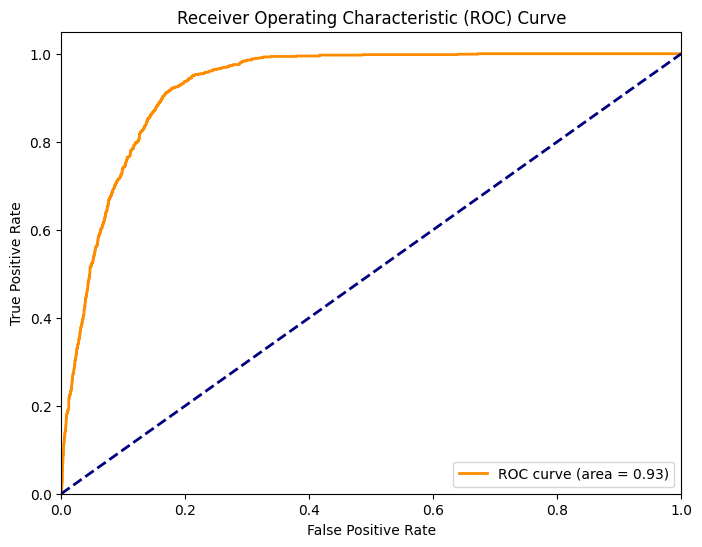

In [56]:

# Get the predicted probabilities for the positive class (class 1)
y_pred_prob = nn_model.predict(X_test)

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#### ROC Curve for Random Forest

258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


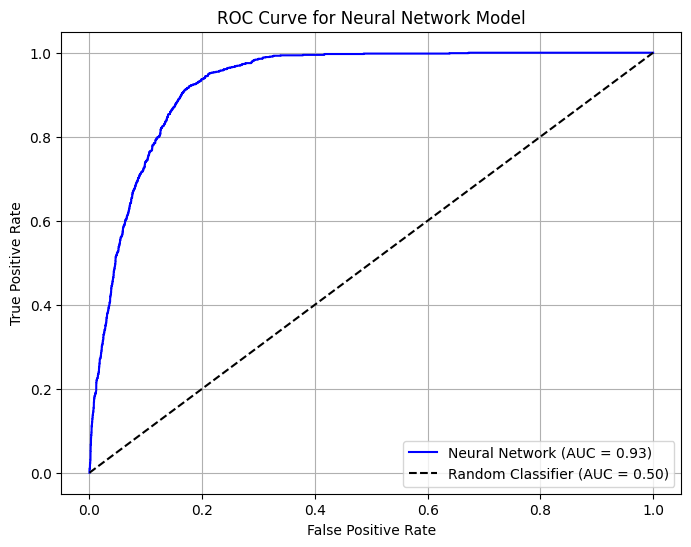

In [54]:
# Predict probabilities for the test set
y_pred_proba_nn = nn_model.predict(X_test).ravel()  # Get probabilities for the positive class

# Calculate the ROC curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_pred_proba_nn)

# Calculate the AUC-ROC score
auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {auc_nn:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Neural Network Model")
plt.legend(loc="lower right")
plt.grid()

# Save the plot
plt.show()
